In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import dlc_practical_prologue as prologue

mini_batch_size = 100
N = 1000

In [2]:
### ONLY FOR THE ANALYSES OF THE RESULTS
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print_shapes_Net = False
print_errors = False

In [4]:
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        if print_shapes_Net:
            print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        if print_shapes_Net:
            print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        if print_shapes_Net:
            print(x.shape)
        x = F.relu(self.fc1(x.view(-1, 256)))
        if print_shapes_Net:
            print(x.shape)
        x = self.fc2(x)
        if print_shapes_Net:
            print(x.shape)
        return x

In [5]:
class Net1(nn.Module):
    def __init__(self, nb_hidden):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(16, 64, kernel_size=3)
        self.fc1 = nn.Linear(32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        if print_shapes_Net:
            print("initial", x.shape) #100 2 10
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        if print_shapes_Net:
            print("conv1",x.shape) #100 16 4
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        if print_shapes_Net:
            print("conv2",x.shape)
        x = F.relu(self.fc1(x.view(-1, 32)))
        if print_shapes_Net:
            print("fc1",x.shape)
        x = self.fc2(x)
        if print_shapes_Net:
            print("final",x.shape) # 100 1 2 
        return x

In [6]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        nb_hidden = 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        if print_shapes_Net:
            print("initial shape", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        if print_shapes_Net:
            print("1 conv",x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        if print_shapes_Net:
            print("2 conv", x.shape)
        x = F.relu(self.conv3(x))
        if print_shapes_Net:
            print("3 conv",x.shape)
        x = F.relu(self.fc1(x.view(-1, 64)))
        if print_shapes_Net:
            print("fc1",x.shape)
        x = self.fc2(x)
        if print_shapes_Net:
            print("final",x.shape)
        return x

######################################################################

In [7]:
def train_model(model, train_input, train_target, mini_batch_size, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    
    for e in range(25):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss = sum_loss + loss.item()

In [8]:
def train_model2(model, train_input, train_target, mini_batch_size, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    
    for e in range(25):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            sum_loss = sum_loss + loss.item()

In [9]:
def compute_nb_errors_classes(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)

        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [10]:
def compute_nb_errors_if(model, input, target):
    nb_errors = 0
    output = model(input)
    _, predicted_classes = output.max(1)
    predicted_target = torch.empty(1000)
    
    for b in range (1000):
        if predicted_classes[2*b] > predicted_classes[2*b + 1]:
            predicted_target[b] = 0
        else:
            predicted_target[b] = 1
        if predicted_target[b] != target[b]:
            nb_errors = nb_errors + 1

    return nb_errors

In [11]:
def compute_nb_errors_targets2(model, input, target):
    nb_errors = 0
    output = model(input)
    _, predicted_classes = output.max(1)
    predicted_target = torch.empty(1000)
    
    for b in range (1000):
        if target[b,int(predicted_classes[b])] <= 0:
            nb_errors = nb_errors + 1

    return nb_errors

In [12]:
def reshape_targets(train_target, test_target):
    new_train_target = torch.empty(1000,2)
    new_test_target = torch.empty(1000,2)
    for i in range(1000):
        if train_target[i] == 1 :
            new_train_target[i,0] = 0
            new_train_target[i,1] = 1

        else:
            new_train_target[i,0] = 1
            new_train_target[i,1] = 0

        if test_target[i] == 1:
            new_test_target[i,0] = 0
            new_test_target[i,1] = 1

        else:
            new_test_target[i,0] = 1
            new_test_target[i,1] = 0      
    return new_train_target, new_test_target

In [13]:
def reshape_classes(train_classes, test_classes):
    #transform classes in a 2000 * 10 
    train_classes2 = torch.empty(2000,10)
    test_classes2 = torch.empty(2000,10)
    for i in range(2000):
        for j in range(10):
            if train_classes[i] == j:
                train_classes2[i,j] = 1
            else:
                train_classes2[i,j] = 0
            if test_classes[i] == j:
                test_classes2[i,j] = 1
            else:
                test_classes2[i,j] = 0
                
    return train_classes2, test_classes2

In [14]:
###ANALYSE THE RESULTS
def analyse_results(train_errors, test_errors, title):
    input_size = 1000
    print('Average train error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(train_errors)) / train_input.size(0),
                                                          np.mean(train_errors), input_size))
    print("Train error standard deviation : {:0.2f}".format(np.std(train_errors)))

    print('Average test error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(test_errors)) / test_input.size(0),
                                                          np.mean(test_errors), input_size))
    print("Test error standard deviation : {:0.2f}".format(np.std(test_errors)))


    train_err = [x*100 / input_size for x in train_errors]
    test_err = [x*100 / input_size for x in test_errors]

    plt.figure
    plt.title(title)
    plt.boxplot([train_err, test_err], labels=['train error', 'test error'])
    plt.ylabel("Error percentage")
    plt.show()

iteration 1/1
train error Net 0.00% 0/2000
test error Net 3.35% 67/2000
train error Net 0.00% 0/1000
test error Net 2.60% 26/1000
train error Net 0.00% 0/1000
test error Net 2.60% 26/1000
Average train error 0.00% 0.00/1000
Train error standard deviation : 0.00
Average test error 1.30% 26.00/1000
Test error standard deviation : 0.00


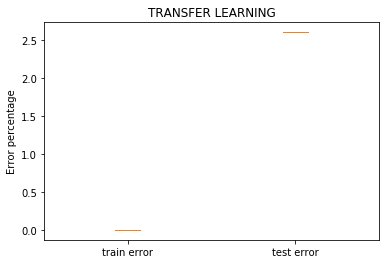

Average train error 0.00% 0.00/1000
Train error standard deviation : 0.00
Average test error 1.20% 24.00/1000
Test error standard deviation : 0.00


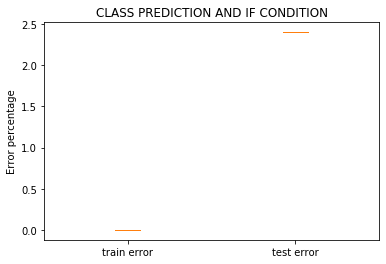

In [16]:
####predict class of each digit
nb = 10
train_errors = []
test_errors = []

train_errors_if = []
test_errors_if = []

for i in range(nb):
    print("iteration {:d}/{:d}".format(i+1,nb))
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    train_input/=255
    test_input/=255

    train_input = train_input.view([2000,1,14,14])
    test_input = test_input.view([2000,1,14,14])

    train_classes, test_classes = reshape_classes(train_classes.view(2000), test_classes.view(2000))

    model = Net2()
    lr = 0.005
    train_model(model, train_input, train_classes, mini_batch_size, lr)

    nb_train_errors = compute_nb_errors_classes(model, train_input, train_classes, mini_batch_size)
    nb_test_errors = compute_nb_errors_classes(model, test_input, test_classes, mini_batch_size)

    if print_errors:
        print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                          nb_train_errors, train_input.size(0)))
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                        nb_test_errors, test_input.size(0)))
    ###predict target using model
    output_train = model(train_input).view([1000,2,10])
    output_test = model(test_input).view([1000,2,10])
    new_train_target, new_test_target = reshape_targets(train_target, test_target)

    model1 = Net1(200)
    train_model2(model1, output_train, new_train_target, mini_batch_size, lr)

    nb_train_errors = compute_nb_errors_targets2(model1, output_train, new_train_target)
    nb_test_errors = compute_nb_errors_targets2(model1, output_test, new_test_target)

    if print_errors:
        print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / output_train.size(0),
                                                          nb_train_errors, output_train.size(0)))
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / output_test.size(0),
                                                        nb_test_errors, output_test.size(0)))
        
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
    nb_train_errors_if = compute_nb_errors_if(model, train_input, train_target)
    nb_test_errors_if = compute_nb_errors_if(model, test_input,  test_target)
    
    if print_errors:
        print('train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_target.size(0),
                                                          nb_train_errors, train_target.size(0)))
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / train_target.size(0),
                                                        nb_test_errors, train_target.size(0)))
    train_errors_if.append(nb_train_errors_if)
    test_errors_if.append(nb_test_errors_if)
analyse_results(train_errors, test_errors, "TRANSFER LEARNING")
analyse_results(train_errors_if, test_errors_if, "CLASS PREDICTION AND IF CONDITION")